In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [3]:
#https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/

#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split






### Local ###
#from data_processing import *



# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [4]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)


def get_torch_device( v=0 ):
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()
    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        if v:  print( "CUDA Available!" )
    else:
        device = torch.device("cpu")
        if v:  print( "NO CUDA" )
    return device

cuda


In [5]:
#choppeddata=pd.read_csv('choppeddata_10_06_2021.csv')#.head()
choppeddata1=pd.read_csv('choppeddata_10_04_2021_randomselector.csv')#.head()
choppeddata2=pd.read_csv('choppeddata_10_06_2021_randomselector.csv')#.head()
print(choppeddata1.shape)
print(choppeddata2.shape)
frames = [choppeddata1, choppeddata2]
choppeddata = pd.concat(frames)
print(choppeddata.shape)

(8088, 10)
(10440, 10)
(18528, 10)


In [6]:
print(choppeddata.shape)
runqty=int(choppeddata.shape[0]/6)
print("total runs:",runqty)
choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)

#put chopped data in np.arrays
State=np.zeros((runqty,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels=np.zeros((runqty,lookback)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,choppeddata.shape[0],6):
            State[runcounter][0][:]=(choppeddata[choppedheaders[:]].iloc[i]).tolist()
            State[runcounter][1][:]=(choppeddata[choppedheaders[:]].iloc[i+1]).tolist()
            State[runcounter][2][:]=(choppeddata[choppedheaders[:]].iloc[i+2]).tolist()
            State[runcounter][3][:]=(choppeddata[choppedheaders[:]].iloc[i+3]).tolist()
            State[runcounter][4][:]=(choppeddata[choppedheaders[:]].iloc[i+4]).tolist()
            Labels[runcounter][:]=(choppeddata[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1
#print(State[0])
#print(Labels)
#print(Labels[:,9]) #just getting finals labels

(18528, 10)
total runs: 3088


In [6]:
#X= range(0,575,6)
#y= range(0,575,6)

X=State
y=Labels[:,lookback-1]
print("x.shape",X.shape)

y=y.reshape(runqty,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.25, #0.33, 
                                                   random_state=random_seed)
#print("Train")
#print(train_x[0])
#print(train_y[0])
print("Test set Y size", test_x.size)
print("Train set Y size", train_y.size)
#print(test_x[0])
#print(test_y[0])
print("Test set C size", test_x.size)
print("Test set Y size", test_y.size)

x.shape (3088, 5, 10)
Test set Y size 38600
Train set Y size 2316
Test set C size 38600
Test set Y size 772


We have a total of 980,185 sequences of training data

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The Torch *Dataset* and *DataLoader* classes are useful for splitting our data into batches and shuffling them.

In [7]:
batch_size = 8
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )
print(train_loader)

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using FloydHub with GPU to run this code, the training time will be significantly reduced.

In [9]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):
    #got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001
    #Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
    #Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
    #Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 200 epoch
    
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model

def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    for i in range( len( test_x ) ):    
        inp = torch.from_numpy(np.array(test_x[i])) # should be 5x1
        labs = torch.from_numpy(np.array(test_y[i])) #should be 1x1
        h = model.init_hidden(inp.shape[0])
        #print("inp",inp)
        #print("labs",labs)
        #print("h",h)
        out, h = model(inp.to(device).float(), h)
        #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        outputs.append( out.cpu().detach().numpy().reshape(-1) )
        targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE
                               
def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []  #labels
    start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE                               

def evaluatefull(model, train_x, train_y, test_x, test_y,maxdifference=0.2, verbose=False):

    m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    print("Vs Training Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)


    #print("Train size:",trainy.size)
    print(gru_outputs[0][4])
    train_successcounter=0
    for i in range(int(trainy.size)):
        #print(testy[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
        #print(train[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))


        #print(trainy[i],gru_outputs[0][i], m(torch.tensor(gru_outputs[0][i])))


        if abs(trainy[i]-gru_outputs[0][i])<maxdifference :
            train_successcounter+=1
        #print(testy[i])
        #print
        #output = m(input)



    test_successcounter=0
    print("Vs Test Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    #print("test size: ",testy.size)

    for i in range(int(testy.size)):


        #, m(torch.tensor(gru_outputs[0][i])))


        if abs(testy[i]-gru_outputs[0][i])<maxdifference :
            test_successcounter+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK" )
        else:
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X" )
            #print(testy[i])
        #print
        #output = m(input)
    print("")
    print(" vs training data=" ,train_successcounter,"/",trainy.size, " vs test data=" ,
          test_successcounter,"/",testy.size,int(100*test_successcounter/testy.size),"%", "at max difference",maxdifference )
    return ( train_successcounter ,test_successcounter)




x.shape (3088, 5, 10)
Starting Training of GRU model


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 40/1000 Done, Total Loss: 0.0856648176786841   Time Elapsed: 0.6026869999999462 seconds
Epoch 80/1000 Done, Total Loss: 0.07079087628678428   Time Elapsed: 0.6082439999998996 seconds
Epoch 120/1000 Done, Total Loss: 0.06657806044214028   Time Elapsed: 0.6019569999999703 seconds
Epoch 160/1000 Done, Total Loss: 0.054646798993410885   Time Elapsed: 0.5957070000000613 seconds
Epoch 200/1000 Done, Total Loss: 0.04821404218182264   Time Elapsed: 0.6319599999999355 seconds
Epoch 240/1000 Done, Total Loss: 0.03955315187431237   Time Elapsed: 0.5990129999998999 seconds
Epoch 280/1000 Done, Total Loss: 0.034198447763653966   Time Elapsed: 0.6067070000000285 seconds
Epoch 320/1000 Done, Total Loss: 0.023836411913183347   Time Elapsed: 0.6099450000000388 seconds
Epoch 360/1000 Done, Total Loss: 0.02270954516821035   Time Elapsed: 0.6129539999999452 seconds
Epoch 400/1000 Done, Total Loss: 0.01663096886245811   Time Elapsed: 0.6114430000000084 seconds
Epoch 440/1000 Done, Total Loss: 0.01464

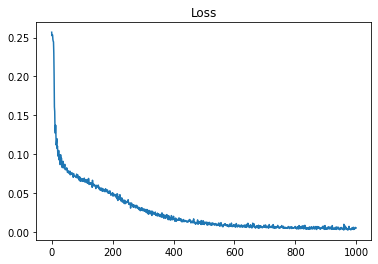

Vs Training Set
Evaluation Time: 0.002263000000084503
sMAPE: 5.297464391987637%
0.047639802
Vs Test Set
Evaluation Time: 0.0012000000001535227
sMAPE: 9.613601270741453%

 vs training data= 2302 / 2316  vs test data= 647 / 772 83 % at max difference 0.2
Vs Training Set
Evaluation Time: 0.0023939999998674466
sMAPE: 5.297464391987637%
0.047639802
Vs Test Set
Evaluation Time: 0.0014080000000831205
sMAPE: 9.613601270741453%

 vs training data= 2313 / 2316  vs test data= 677 / 772 87 % at max difference 0.3
Vs Training Set
Evaluation Time: 0.0017829999999321444
sMAPE: 5.297464391987637%
0.047639802
Vs Test Set
Evaluation Time: 0.001326000000062777
sMAPE: 9.613601270741453%

 vs training data= 2315 / 2316  vs test data= 689 / 772 89 % at max difference 0.4
Vs Training Set
Evaluation Time: 0.0023360000000138825
sMAPE: 5.297464391987637%
0.047639802
Vs Test Set
Evaluation Time: 0.0010810000001129083
sMAPE: 9.613601270741453%

 vs training data= 2316 / 2316  vs test data= 701 / 772 90 % at max d

/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:130: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [11]:
lr = 0.0005
batch_size = 8
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

X=State
y=Labels[:,lookback-1]
print("x.shape",X.shape)
y=y.reshape(runqty,1)


random_seed=int(time.time())
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.25, #0.33, 
                                                   random_state=random_seed)

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )


gru_model = train(train_loader, lr , hidden_dim=128, EPOCHS=1000, model_type="GRU")
train2 ,test2=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.2)
train3 ,test3=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.3)
train4 ,test4=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.4)
train5 ,test5=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.5)



In [12]:


import time
from datetime import date

today = date.today()    
todaydate = today.strftime("%m_%d_%Y")
print(todaydate)
torch.save(gru_model,"currentmodel_"+todaydate+"b.pt")
print("model saved")

10_10_2021
model saved


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Test model on new data

In [7]:
def evaluate_episode(model, data,  maxdifference=0.2, verbose=False):

   
    model.eval()
    inp = torch.from_numpy(np.array(data)) # should be 5x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #print("model output",out)
    return out

In [10]:


gru_model3=torch.load('currentmodel_10_10_2021b.pt')
gru_model3.eval()
print("loaded")

loaded


In [16]:
randomindex=random.randint(0,225)
print("index=",randomindex)

exampledata=np.expand_dims(test_x[207, 0:5, 0:10], axis=0)

print(exampledata.shape)
prediction=evaluate_episode(gru_model3, exampledata)

print("prediction",float(prediction), "  actual",test_y[randomindex])

index= 224
(1, 5, 10)
prediction 0.09528319537639618   actual [0.]


## simlulate a buffer of 10 timesteps entering the classifier over a 1 episode, and classifying them. Filling empty data with zeroes or ones

In [11]:
outputlist=[]

randomindex=random.randint(0,225)
print("index=",randomindex)
exampledata=np.expand_dims(test_x[randomindex, 0:5, 0:10], axis=0)


#print(temparray.shape)
#temparray=np.expand_dims(temparray, axis=1)

#print(temparray.shape)
#print(temparray)

#temparray2=test_x[randomindex, 0:5, 0]
#temparray2=np.expand_dims(temparray2, axis=1)

for i in range(9):
    if i!=10:
        temparray=np.ones((5,1)) #test_x[randomindex, 0:5, 0]   #zeroes or "ones" here seems to work equally well. 
    
    for j in range(8-i):
        #temparray2=test_x[randomindex, 0:5, 0]
        #temparray2=np.expand_dims(temparray2, axis=1)
        temparray=np.append(temparray,np.ones((5,1)),axis=1)       #zeroes or "ones" here seems to work equally well. 
        #temparray=np.append(temparray,temparray2,axis=1)
        #temparray=np.append(np.zeros((5,1)),temparray,axis=1)   
    
    for j in range(i+1):

        temparray2=test_x[randomindex, 0:5, j]
        temparray2=np.expand_dims(temparray2, axis=1)
        temparray=np.append(temparray,temparray2,axis=1)
        #temparray=np.append(np.zeros((5,1)),temparray,axis=1)

    
    #print(temparray)
    temparray=np.expand_dims(temparray, axis=0)
    outputpartial=evaluate_episode(gru_model3, temparray)
    
    
    outputlist.append(float(outputpartial))

print("final partial data")
print(temparray)   
print("")
print("full data")
print(exampledata)




#print("prediction from",x," timesteps",float(outputpartial),"actual",test_y[randomindex])
print("predictions:",outputlist)


#print("full data")
#print(exampledata)
print("")
#print("evaluating all 10 timesteps")

outputfull=evaluate_episode(gru_model3, exampledata)

print("")

#print("evaluating 1st timestep repeated 10 times")


#print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
print("prediction from 10 timesteps",float(outputfull),"actual",test_y[randomindex])


index= 84


NameError: name 'test_x' is not defined

## classifying progression of 10 actual forces and torques in a sucessful sequence longer than 10

In [12]:
originaldata=pd.read_csv('forcetorquebuttonresults_renormalized_10_06_2021.csv')#.head()
print(originaldata.shape)
headers=[]
lookback=30 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    headers.append("header"+label)
print(headers)

(7200, 30)
['header0', 'header1', 'header2', 'header3', 'header4', 'header5', 'header6', 'header7', 'header8', 'header9', 'header10', 'header11', 'header12', 'header13', 'header14', 'header15', 'header16', 'header17', 'header18', 'header19', 'header20', 'header21', 'header22', 'header23', 'header24', 'header25', 'header26', 'header27', 'header28', 'header29']


In [28]:
print(originaldata[headers[20:30]].iloc[4039:4044])

      header20  header21  header22  header23  header24  header25  header26  \
4039  0.313334  0.297908  0.300916  0.295691  0.304691  0.297850  0.298842   
4040  0.887794  0.927183  0.923606  0.929387  0.921559  0.932170  0.925471   
4041  0.689476  0.707595  0.706714  0.707579  0.702587  0.708988  0.708745   
4042  0.516504  0.504406  0.494093  0.490169  0.484280  0.477127  0.479447   
4043  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

      header27  header28  header29  
4039  0.298431  0.323285       NaN  
4040  0.922702  0.851257       NaN  
4041  0.709223  0.693128       NaN  
4042  0.476531  0.484857       NaN  
4043  0.000000  1.000000       NaN  


In [13]:

#print(originaldata[headers[0:30]].iloc[4039:4044])
#print(originaldata[headers[0:30]].iloc[4039:4044].to_numpy()
classifytest=originaldata[headers[19:29]].iloc[4038:4043].to_numpy()
labelstest=originaldata[headers[19:29]].iloc[4043].to_numpy()
print(classifytest)
classifytest=np.expand_dims(classifytest, axis=0)
print(classifytest.shape)
print(labelstest)

outputfull=evaluate_episode(gru_model3, classifytest)

print("")

#print("evaluating 1st timestep repeated 10 times")


#print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
print("prediction from 10 timesteps",float(outputfull),"actual",labelstest[9])

[[0.54251199 0.52489482 0.52926319 0.5065195  0.49991385 0.49536954
  0.48716645 0.48923134 0.48428939 0.51027604]
 [0.37858933 0.31333356 0.29790778 0.30091579 0.29569087 0.30469148
  0.29785046 0.29884238 0.29843066 0.32328525]
 [0.93041265 0.88779361 0.92718331 0.92360628 0.92938742 0.92155946
  0.9321705  0.92547146 0.92270207 0.85125721]
 [0.63809043 0.68947554 0.70759451 0.70671384 0.70757924 0.7025874
  0.70898769 0.70874526 0.70922296 0.69312779]
 [0.54499817 0.51650444 0.50440577 0.49409301 0.49016859 0.48428045
  0.47712741 0.4794472  0.4765313  0.48485743]]
(1, 5, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

prediction from 10 timesteps 1.0079834461212158 actual 1.0


In [17]:

okcounter=0
for i in range(20):
    classifytest=originaldata[headers[i:10+i]].iloc[4296:4301].to_numpy()
    labelstest=originaldata[headers[i:10+i]].iloc[4301].to_numpy()
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model3, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")


    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    
    if abs(float(outputfull)-labelstest[9])>0.3:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

prediction from timestep 0 - 10  : -0.02594076097011566 actual 0.0 OK
prediction from timestep 1 - 11  : 0.0480835884809494 actual 0.0 OK
prediction from timestep 2 - 12  : 0.9821402430534363 actual 0.0 X
prediction from timestep 3 - 13  : 0.11055419594049454 actual 0.0 OK
prediction from timestep 4 - 14  : -0.1168106347322464 actual 0.0 OK
prediction from timestep 5 - 15  : 0.8755136132240295 actual 0.0 X
prediction from timestep 6 - 16  : 0.047825887799263 actual 0.0 OK
prediction from timestep 7 - 17  : -0.15455161035060883 actual 0.0 OK
prediction from timestep 8 - 18  : 0.05473002791404724 actual 0.0 OK
prediction from timestep 9 - 19  : 0.04417501389980316 actual 0.0 OK
prediction from timestep 10 - 20  : 0.030899599194526672 actual 0.0 OK
prediction from timestep 11 - 21  : -0.02510102093219757 actual 0.0 OK
prediction from timestep 12 - 22  : -0.018104642629623413 actual 0.0 OK
prediction from timestep 13 - 23  : 0.006784290075302124 actual 0.0 OK
prediction from timestep 14 - 

In [15]:
originaldata.iloc[4890:4896]

,header0,header1,header2,header3,header4,header5,header6,header7,header8,header9,...,header20,header21,header22,header23,header24,header25,header26,header27,header28,header29
4890,0.519653,0.629009,0.666283,0.757858,0.748447,0.748698,0.751999,0.743304,0.741959,0.748569,...,0.785070,0.768524,0.756693,0.763045,0.771942,0.774374,NaN,NaN,NaN,NaN
4891,0.372140,0.333817,0.319136,0.330614,0.324397,0.318553,0.308498,0.310825,0.340429,0.380643,...,0.510981,0.545773,0.534438,0.555681,0.578675,0.561716,NaN,NaN,NaN,NaN
4892,0.932075,0.880805,0.871212,0.782250,0.917737,0.913229,0.930457,0.932578,0.922336,0.936276,...,0.951116,0.928739,0.959949,0.949016,0.937812,0.899633,NaN,NaN,NaN,NaN
4893,0.641091,0.669016,0.684142,0.675920,0.699291,0.686433,0.692765,0.690845,0.670727,0.643720,...,0.498684,0.474195,0.481877,0.466092,0.447252,0.446521,NaN,NaN,NaN,NaN
4894,0.550714,0.634439,0.686677,0.743846,0.772609,0.768783,0.769648,0.771199,0.775574,0.782100,...,0.835276,0.823710,0.817117,0.822949,0.825044,0.824857,NaN,NaN,NaN,NaN
4895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN


In [16]:
okcounter=0
for i in range(20):
    classifytest=originaldata[headers[i:10+i]].iloc[4890:4895].to_numpy()
    labelstest=originaldata[headers[i:10+i]].iloc[4895].to_numpy()
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model3, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")


    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    
    if abs(float(outputfull)-labelstest[9])>0.3:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

prediction from timestep 0 - 10  : -0.09742848575115204 actual 0.0 OK
prediction from timestep 1 - 11  : -0.02650107443332672 actual 0.0 OK
prediction from timestep 2 - 12  : -0.005853220820426941 actual 0.0 OK
prediction from timestep 3 - 13  : -0.0391157865524292 actual 0.0 OK
prediction from timestep 4 - 14  : 0.015127182006835938 actual 0.0 OK
prediction from timestep 5 - 15  : 0.035328879952430725 actual 0.0 OK
prediction from timestep 6 - 16  : 0.01412925124168396 actual 0.0 OK
prediction from timestep 7 - 17  : -0.05517677962779999 actual 0.0 OK
prediction from timestep 8 - 18  : 0.054900944232940674 actual 0.0 OK
prediction from timestep 9 - 19  : 0.6387906670570374 actual 0.0 X
prediction from timestep 10 - 20  : 1.000757098197937 actual 0.0 X
prediction from timestep 11 - 21  : 0.4143144190311432 actual 0.0 X
prediction from timestep 12 - 22  : 0.2703593969345093 actual 0.0 OK
prediction from timestep 13 - 23  : 0.2673940658569336 actual 0.0 OK
prediction from timestep 14 - 2